# improve version for users.ipynb

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
SEED = 42
np.random.seed(SEED)

BASE = Path("Datasets/mockup_ver2/")
BASE.mkdir(parents=True, exist_ok=True)
TX_PATH = BASE / "transactions.csv"
USERS_PATH = BASE / "users.csv"
OUTPUT_PATH = BASE / "users_features_with_segments.csv"

def load_and_preprocess_transactions(file_path):
    """Load and preprocess transaction data"""
    if not file_path.exists():
        raise FileNotFoundError(f"Transaction file not found: {file_path}")
    
    tx = pd.read_csv(file_path)
    tx["timestamp"] = pd.to_datetime(tx["timestamp"], format="%d/%m/%Y %H:%M")
    
    tx["order_date"] = tx["timestamp"].dt.date
    tx["order_hour"] = tx["timestamp"].dt.hour
    tx["dayofweek"] = tx["timestamp"].dt.dayofweek
    tx["is_weekend"] = tx["dayofweek"].isin([5, 6]).astype(int)
    tx["month"] = tx["timestamp"].dt.month
    tx["unit_price"] = np.where(tx["qty"] > 0, tx["price"] / tx["qty"], np.nan)
    
    print(f"Loaded {len(tx):,} transactions from {tx['user_id'].nunique():,} users")
    return tx

def aggregate_transactions(tx):
    """Aggregate transactions by user and transaction_id"""
    txn = (
        tx.groupby(["user_id", "transaction_id"], as_index=False)
        .agg({
            "timestamp": "min",
            "qty": "sum",
            "price": "sum",
            "unit_price": "mean",
            "order_hour": "min",
            "dayofweek": "min",
            "is_weekend": "max",
            "month": "min",
        })
        .sort_values(["user_id", "timestamp"])
    )
    
    txn["next_ts"] = txn.groupby("user_id")["timestamp"].shift(-1)
    txn["days_to_next"] = (txn["next_ts"] - txn["timestamp"]).dt.days
    txn["repeat_30d"] = (
        txn["days_to_next"].notna() & (txn["days_to_next"] <= 30)
    ).astype(int)
    
    return txn

def calculate_loyalty_scores(txn):
    """Calculate customer loyalty scores using repeat purchase prediction"""
    X_rep = pd.get_dummies(
        txn[["is_weekend", "month", "order_hour", "price"]],
        columns=["month", "order_hour"], 
        drop_first=True
    ).fillna(0)
    y_rep = txn["repeat_30d"]
    
    if y_rep.nunique() == 1:
        p_avg = float(y_rep.mean())
        txn["pred_repeat_prob"] = p_avg
    else:
        logit = LogisticRegression(max_iter=1000, random_state=SEED)
        logit.fit(X_rep, y_rep)
        txn["pred_repeat_prob"] = logit.predict_proba(X_rep)[:, 1]
    
    user_loyalty = txn.groupby("user_id")["pred_repeat_prob"].mean().rename("loyalty_score")
    return user_loyalty, txn

def calculate_basket_sizes(txn):
    """Calculate expected basket sizes using Poisson regression"""
    X_bsk = pd.get_dummies(
        txn[["is_weekend", "month", "order_hour"]],
        columns=["month", "order_hour"], 
        drop_first=True
    ).fillna(0)
    y_bsk = txn["qty"].clip(lower=0)
    
    if len(txn) < 30 or y_bsk.nunique() <= 1:
        pred_basket = np.repeat(y_bsk.mean(), len(txn))
    else:
        poisson = PoissonRegressor(alpha=0.1, max_iter=500)
        poisson.fit(X_bsk, y_bsk)
        pred_basket = poisson.predict(X_bsk).clip(min=0)
    
    txn["pred_basket_qty"] = pred_basket
    user_basket = txn.groupby("user_id")["pred_basket_qty"].mean().rename("expected_basket_items")
    return user_basket

def calculate_price_elasticity(txn):
    """Calculate price elasticity for each user"""
    def elasticity_per_user(g):
        g = g.dropna(subset=["qty", "unit_price"]).copy()
        g = g[(g["qty"] > 0) & (g["unit_price"] > 0)]
        
        if g["unit_price"].nunique() < 3 or len(g) < 5:
            return np.nan
        
        try:
            X = np.log(g[["unit_price"]].values)
            y = np.log(g["qty"].values)
            lr = LinearRegression()
            lr.fit(X, y)
            return float(lr.coef_[0])
        except:
            return np.nan
    
    user_elast = txn.groupby("user_id").apply(elasticity_per_user, include_groups=False).rename("price_elasticity")
    
    def global_elasticity(df):
        d = df.dropna(subset=["qty", "unit_price"])
        d = d[(d["qty"] > 0) & (d["unit_price"] > 0)]
        
        if d["unit_price"].nunique() < 3 or len(d) < 20:
            return -1.8
        
        try:
            X = np.log(d[["unit_price"]].values)
            y = np.log(d["qty"].values)
            lr = LinearRegression().fit(X, y)
            return float(lr.coef_[0])
        except:
            return -1.8
    
    global_elast = global_elasticity(txn)
    user_elast = user_elast.fillna(global_elast)
    return user_elast

def find_optimal_clusters(features, k_range=range(2, 11), feature_cols=None):
    """Find optimal number of clusters using multiple metrics"""
    if feature_cols is None:
        feature_cols = ["loyalty_score", "expected_basket_items", "price_elasticity"]
    
    X = features[feature_cols].copy()
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median(numeric_only=True))
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    results = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init=20, random_state=SEED)
        labels = kmeans.fit_predict(X_scaled)
        
        sse = float(kmeans.inertia_)
        sil = silhouette_score(X_scaled, labels) if k > 1 else np.nan
        ch = calinski_harabasz_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        
        results.append({
            "K": k, 
            "SSE": sse, 
            "Silhouette": sil, 
            "CalinskiHarabasz": ch, 
            "DaviesBouldin": db
        })
    
    metrics_df = pd.DataFrame(results)
    
    metrics_df["rank_sil"] = metrics_df["Silhouette"].rank(ascending=False, method="min")
    metrics_df["rank_ch"] = metrics_df["CalinskiHarabasz"].rank(ascending=False, method="min")
    metrics_df["rank_db"] = metrics_df["DaviesBouldin"].rank(ascending=True, method="min")
    metrics_df["rank_total"] = (
        metrics_df["rank_sil"] * 0.5 + 
        metrics_df["rank_ch"] * 0.3 + 
        metrics_df["rank_db"] * 0.2
    )
    
    best_sil_k = int(metrics_df.loc[metrics_df["Silhouette"].idxmax(), "K"])
    best_combo_k = int(metrics_df.sort_values("rank_total").iloc[0]["K"])
    
    print("Clustering Evaluation Results:")
    print(metrics_df[["K", "SSE", "Silhouette", "CalinskiHarabasz", "DaviesBouldin", "rank_total"]].round(3))
    print(f"\nRecommendations:")
    print(f"Best by Silhouette Score: K = {best_sil_k}")
    print(f"Best by Combined Metrics: K = {best_combo_k}")
    
    return metrics_df, best_combo_k, scaler, X_scaled

def perform_clustering(features, k, scaler, X_scaled, feature_cols=None):
    """Perform K-means clustering and create segment descriptions"""
    if feature_cols is None:
        feature_cols = ["loyalty_score", "expected_basket_items", "price_elasticity"]
    
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=SEED)
    features["segment"] = kmeans.fit_predict(X_scaled)
    
    centers = pd.DataFrame(
        scaler.inverse_transform(kmeans.cluster_centers_),
        columns=feature_cols
    )
    
    segment_descriptions = []
    for i, row in centers.iterrows():
        desc = (
            f"S{i}: loyalty~{row['loyalty_score']:.2f}, "
            f"basket~{row['expected_basket_items']:.2f}, "
            f"elast~{row['price_elasticity']:.2f}"
        )
        segment_descriptions.append(desc)
    
    seg_map = {i: desc for i, desc in enumerate(segment_descriptions)}
    features["segment_desc"] = features["segment"].map(seg_map)
    
    print("Segment Summary:")
    for seg in range(k):
        count = features[features["segment"] == seg].shape[0]
        pct = count / len(features) * 100
        print(f"  {segment_descriptions[seg]} ({count} users, {pct:.1f}%)")
    
    return features, centers

def create_visualizations(features):
    """Create visualizations for the segmentation analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    segment_counts = features["segment"].value_counts().sort_index()
    axes[0, 0].bar(segment_counts.index, segment_counts.values)
    axes[0, 0].set_title("Distribution of Customers by Segment")
    axes[0, 0].set_xlabel("Segment")
    axes[0, 0].set_ylabel("Number of Customers")
    
    feature_cols = ["loyalty_score", "expected_basket_items", "price_elasticity"]
    
    for i, col in enumerate(feature_cols):
        if i == 0:
            ax = axes[0, 1]
        elif i == 1:
            ax = axes[1, 0]
        else:
            ax = axes[1, 1]
        
        for segment in sorted(features["segment"].unique()):
            data = features[features["segment"] == segment][col]
            ax.hist(data, alpha=0.6, label=f"Segment {segment}", bins=20)
        
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = features[feature_cols + ["segment"]].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
    plt.title("Feature Correlation Matrix")
    plt.show()


Loaded 14,102 transactions from 1,000 users
Using preferred k = 5
Segment Summary:
  S0: loyalty~0.87, basket~2.97, elast~0.01 (103 users, 10.3%)
  S1: loyalty~0.95, basket~3.00, elast~0.20 (209 users, 20.9%)
  S2: loyalty~0.95, basket~3.00, elast~-0.27 (206 users, 20.6%)
  S3: loyalty~0.92, basket~2.98, elast~-0.14 (283 users, 28.3%)
  S4: loyalty~0.91, basket~2.98, elast~0.31 (199 users, 19.9%)


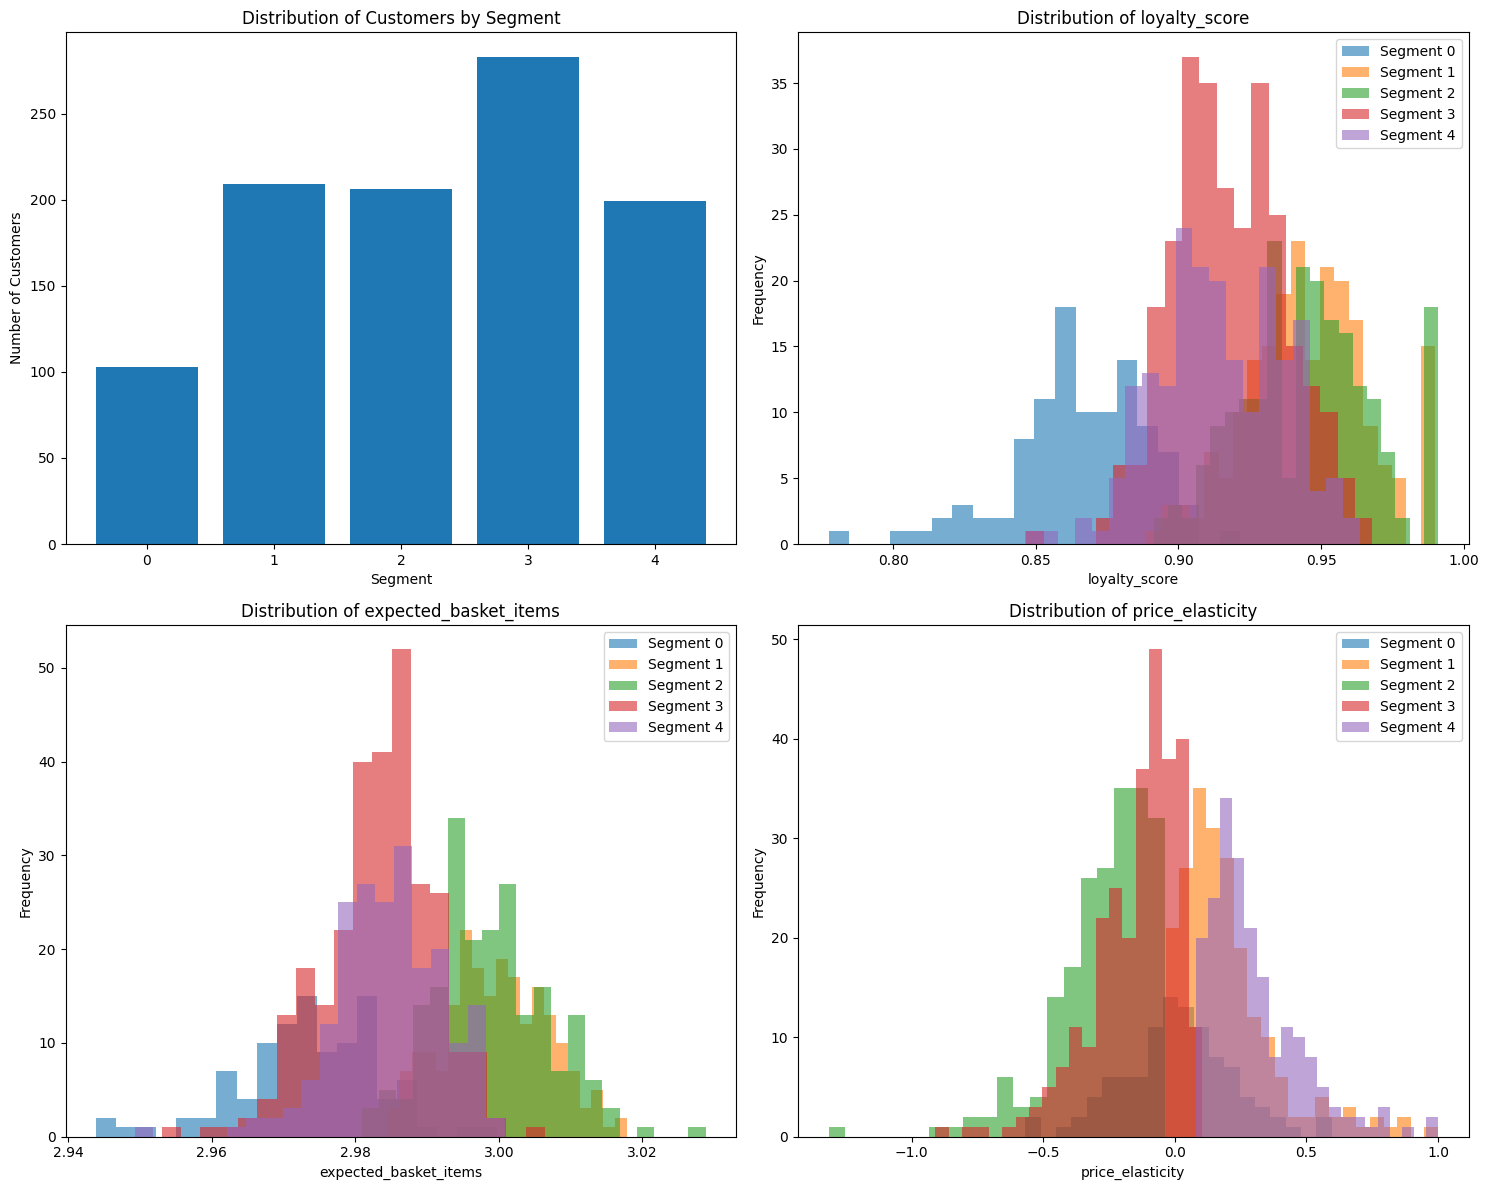

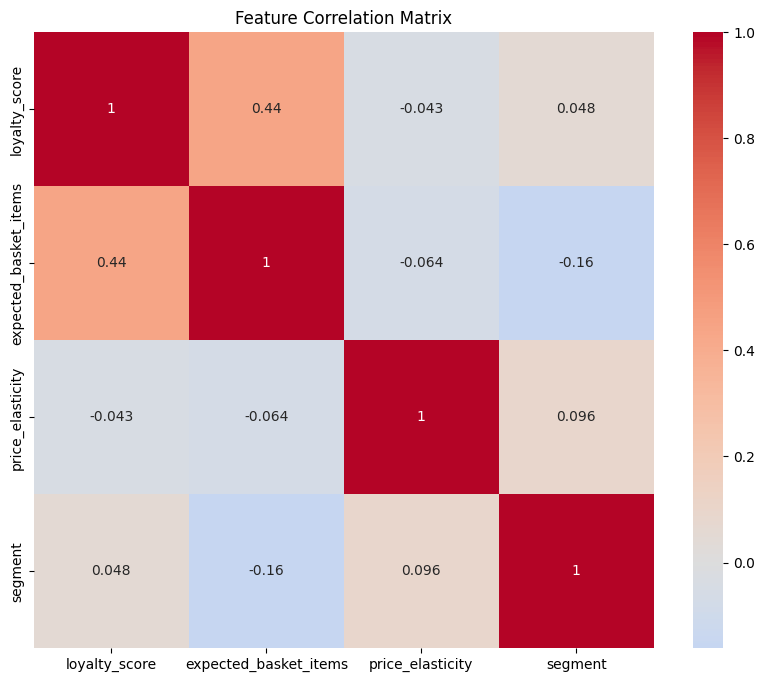

Saved -> Datasets\mockup_ver2\users_features_with_segments.csv

Sample Results:
  user_id  loyalty_score  expected_basket_items  price_elasticity  segment  \
0   U0001          0.989                   3.01              0.06        1   
1   U0002          0.928                   2.98              0.18        4   
2   U0003          0.894                   3.00              0.44        4   
3   U0004          0.988                   3.01             -0.31        2   
4   U0005          0.909                   3.00              0.11        1   
5   U0006          0.989                   3.00             -0.48        2   
6   U0007          0.933                   3.00             -0.09        2   
7   U0008          0.971                   3.01             -0.11        2   
8   U0009          0.929                   2.99             -0.15        3   
9   U0010          0.907                   2.98              0.51        4   

                                 segment_desc  
0   S1: loyal

In [6]:
def main(preferred_k=None):
    """Main execution function"""
    try:
        tx = load_and_preprocess_transactions(TX_PATH)
        txn = aggregate_transactions(tx)
        
        user_loyalty, txn = calculate_loyalty_scores(txn)
        user_basket = calculate_basket_sizes(txn)
        user_elasticity = calculate_price_elasticity(txn)
        
        user_features = pd.concat([user_loyalty, user_basket, user_elasticity], axis=1).reset_index()
        
        user_features["loyalty_score"] = user_features["loyalty_score"].clip(0, 1)
        user_features["expected_basket_items"] = user_features["expected_basket_items"].clip(0, 50)
        user_features["price_elasticity"] = user_features["price_elasticity"].clip(-5, 1)
        
        feature_cols = ["loyalty_score", "expected_basket_items", "price_elasticity"]
        
        if preferred_k is None:
            metrics_df, best_k, scaler, X_scaled = find_optimal_clusters(user_features, feature_cols=feature_cols)
        else:
            best_k = preferred_k
            print(f"Using preferred k = {preferred_k}")
            # Still need to prepare data for clustering
            X = user_features[feature_cols].copy()
            X = X.replace([np.inf, -np.inf], np.nan)
            X = X.fillna(X.median(numeric_only=True))
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            metrics_df = None
        
        user_features, centers = perform_clustering(user_features, best_k, scaler, X_scaled, feature_cols)
        
        create_visualizations(user_features)
        
        output_cols = ["user_id", "loyalty_score", "expected_basket_items", "price_elasticity", "segment", "segment_desc"]
        final_df = user_features[output_cols].copy()
        
        final_df["loyalty_score"] = final_df["loyalty_score"].round(3)
        final_df["expected_basket_items"] = final_df["expected_basket_items"].round(2)
        final_df["price_elasticity"] = final_df["price_elasticity"].round(2)
        
        final_df.to_csv(OUTPUT_PATH, index=False)
        print(f"Saved -> {OUTPUT_PATH}")
        
        print("\nSample Results:")
        print(final_df.head(10))
        
        return final_df, metrics_df, centers
        
    except Exception as e:
        print(f"Error: {e}")
        raise

if __name__ == "__main__":
    # Option 1: Use automatic k selection
    # results, clustering_metrics, cluster_centers = main()
    
    # Option 2: Use your preferred k (change the number as needed)
    results, clustering_metrics, cluster_centers = main(preferred_k=5)
    
    # Option 3: You can also set it dynamically